# Redlining, Race-Exclusive Deed Restriction Language, and Neighborhood Racial Composition in Houston
## 2202PHW Final Project
### Aislyn Schalck, 08-12-2020
# 
Note that this isn't the only explainatory text. This project has text commentary interspaced throughout the code/graphs.

# Project Overview
Housing practices discriminating on the basis of race have been present in the U.S. since the nation's founding, and were formally codified into federal law by the New Deal's Federal Housing Act of 1934. In addition to federal discriminatory practices, local laws in many Southern states during this era formally enforced racial housing segregation via "whites-only" deed restrictions in many neighborhoods. The Fair Housing Act of 1968 nationally prohibited discrimination in housing sales and financing on the basis of race. However, federal and local agencies were given little power and resources to mitigate racist housing practices until further amendments to the act were passed in the 1980's. To this day, many cities in the U.S. are known to exhibit substantial geographical racial segregation. This report uses historical loan-security data maps, current (unenforceable) race-prohibiting deed restrictions, and census data to graphically examine the lasting effects of racist housing policy's in Houston.   

In [169]:
#import libraries
import numpy as np
import pandas as pd
import scipy
import os
from matplotlib import cm
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as clr
from shapely.geometry import Polygon
from shapely.geometry import shape

#  
## Census race data

Data files from the census (data table B02001 directly from the census website for the years 2010 and 2018 for Harris County, TX tracts) are used throughout the project. Since the census is only conducted every 10 years, population counts are projected estimates (performed by the census bureau ) for the number of people of a given race in a given census tract. The most important column is "id" (the census tract ID), which is used throughout the project as a unique identifier. These tables only consider "race" and not ethnicity (i.e. "hispanic" or "non-hispanic"). 

In [2]:
##race data
#these are "estimated" counts of people by race from the census for 2010 and 2018
#read as pandas dataframes
race_2010_raw = pd.read_csv("/Users/aschalck/Desktop/final_project/racedata/ACSDT5Y2010.B02001_data_with_overlays_2020-08-07T121140.csv", skiprows=1)
race_2018_raw = pd.read_csv("/Users/aschalck/Desktop/final_project/racedata/ACSDT5Y2018.B02001_data_with_overlays_2020-08-07T121140.csv", skiprows=1)

In [3]:
#the raw data has lots of columns I'm not interested in, and very long column names
race_2010_raw.head()

,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!White alone,Margin of Error!!Total!!White alone,Estimate!!Total!!Black or African American alone,Margin of Error!!Total!!Black or African American alone,Estimate!!Total!!American Indian and Alaska Native alone,Margin of Error!!Total!!American Indian and Alaska Native alone,...,Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone,Margin of Error!!Total!!Native Hawaiian and Other Pacific Islander alone,Estimate!!Total!!Some other race alone,Margin of Error!!Total!!Some other race alone,Estimate!!Total!!Two or more races,Margin of Error!!Total!!Two or more races,Estimate!!Total!!Two or more races!!Two races including Some other race,Margin of Error!!Total!!Two or more races!!Two races including Some other race,"Estimate!!Total!!Two or more races!!Two races excluding Some other race, and three or more races","Margin of Error!!Total!!Two or more races!!Two races excluding Some other race, and three or more races"
0,1400000US48201320100,"Census Tract 3201, Harris County, Texas",2853,451,1295,328,0,127,11,20,...,0,127,1476,452,45,58,45,58,0,127
1,1400000US48201350700,"Census Tract 3507, Harris County, Texas",1918,146,1816,153,0,127,0,127,...,0,127,14,22,0,127,0,127,0,127
2,1400000US48201422402,"Census Tract 4224.02, Harris County, Texas",5771,820,3308,706,793,433,15,23,...,0,127,1344,480,63,112,63,112,0,127
3,1400000US48201550100,"Census Tract 5501, Harris County, Texas",4576,600,1595,421,2442,490,0,127,...,0,127,498,347,21,30,0,127,21,30
4,1400000US48201250200,"Census Tract 2502, Harris County, Texas",7488,723,3982,778,2043,519,87,116,...,0,127,1099,451,13,22,0,127,13,22


#  
## Preparing the census data

To prepare the data for further analysis, and merging with other data tables, I gave the columns simpler names, and filtered unwanted columns. Also, I converted people counts into percentages for each tract. I combined non-black and non-white single-race peoples (i.e. Asian, Native American, Pacific Islander) into a category I called "other" because many of their counts were small anyways. I categorized all people listed as "two or more races" as "mixed". The processed tables are dislayed below. If this project included three or more years, I would have made this into a function and probably made the data long-format instead of the current wide-format. 

In [4]:
#prepare the 2010 race data to merge

#rename the important columns
race_2010 = race_2010_raw.rename(columns={'Estimate!!Total':'total_2010',
                                          'Estimate!!Total!!White alone':'white_alone_2010',
                                          'Estimate!!Total!!Black or African American alone':'black_alone_2010',
                                          'Estimate!!Total!!Two or more races':'mixed_race_2010'})

#select the important columns
race_2010 = race_2010[['id','total_2010','white_alone_2010','black_alone_2010','mixed_race_2010']]

#calculate percentages
race_2010['percent_white_2010'] = race_2010['white_alone_2010']/race_2010['total_2010']
race_2010['percent_black_2010'] = race_2010['black_alone_2010']/race_2010['total_2010']
race_2010['percent_mixed_2010'] = race_2010['mixed_race_2010']/race_2010['total_2010']
race_2010['percent_other_2010'] = 1-(race_2010['percent_white_2010']+race_2010['percent_black_2010']+race_2010['percent_mixed_2010'])

#select the columns for merging
race_2010 = race_2010.iloc[:,[0,1,5,6,7,8]]

race_2010.head()

,id,total_2010,percent_white_2010,percent_black_2010,percent_mixed_2010,percent_other_2010
0,1400000US48201320100,2853,0.453908,0.000000,0.015773,0.530319
1,1400000US48201350700,1918,0.946820,0.000000,0.000000,0.053180
2,1400000US48201422402,5771,0.573211,0.137411,0.010917,0.278461
3,1400000US48201550100,4576,0.348558,0.533654,0.004589,0.113199
4,1400000US48201250200,7488,0.531784,0.272837,0.001736,0.193643


In [5]:
#the raw data has lots of columns I'm not interested in, and very long column names
#the structure is the same as the 2010 data
race_2018_raw.head()

,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!White alone,Margin of Error!!Total!!White alone,Estimate!!Total!!Black or African American alone,Margin of Error!!Total!!Black or African American alone,Estimate!!Total!!American Indian and Alaska Native alone,Margin of Error!!Total!!American Indian and Alaska Native alone,...,Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone,Margin of Error!!Total!!Native Hawaiian and Other Pacific Islander alone,Estimate!!Total!!Some other race alone,Margin of Error!!Total!!Some other race alone,Estimate!!Total!!Two or more races,Margin of Error!!Total!!Two or more races,Estimate!!Total!!Two or more races!!Two races including Some other race,Margin of Error!!Total!!Two or more races!!Two races including Some other race,"Estimate!!Total!!Two or more races!!Two races excluding Some other race, and three or more races","Margin of Error!!Total!!Two or more races!!Two races excluding Some other race, and three or more races"
0,1400000US48201551400,"Census Tract 5514, Harris County, Texas",5130,536,2891,502,810,271,0,19,...,6,28,503,433,150,166,19,25,131,165
1,1400000US48201552500,"Census Tract 5525, Harris County, Texas",11478,808,7620,746,1655,706,53,90,...,0,21,497,453,338,211,253,169,85,89
2,1400000US48201210700,"Census Tract 2107, Harris County, Texas",2657,229,1518,362,395,111,35,40,...,0,13,546,246,162,153,111,132,51,71
3,1400000US48201211000,"Census Tract 2110, Harris County, Texas",1941,332,691,282,1105,213,0,13,...,0,13,98,69,10,11,0,13,10,11
4,1400000US48201211900,"Census Tract 2119, Harris County, Texas",5478,772,4298,642,43,47,121,139,...,0,19,950,544,66,59,45,46,21,35


In [6]:
#if I had three or more years I would make this into a function
#prepare the 2018 race data to merge

#rename the important columns
race_2018 = race_2018_raw.rename(columns={'Estimate!!Total':'total_2018',
                                          'Estimate!!Total!!White alone':'white_alone_2018',
                                          'Estimate!!Total!!Black or African American alone':'black_alone_2018',
                                          'Estimate!!Total!!Two or more races':'mixed_race_2018'})

#select the important columns
race_2018 = race_2018[['id','total_2018','white_alone_2018','black_alone_2018','mixed_race_2018']]

#calculate percentages
race_2018['percent_white_2018'] = race_2018['white_alone_2018']/race_2018['total_2018']
race_2018['percent_black_2018'] = race_2018['black_alone_2018']/race_2018['total_2018']
race_2018['percent_mixed_2018'] = race_2018['mixed_race_2018']/race_2018['total_2018']
race_2018['percent_other_2018'] = 1-(race_2018['percent_white_2018']+race_2018['percent_black_2018']+race_2018['percent_mixed_2018'])

#select the columns for merging
race_2018 = race_2018.iloc[:,[0,1,5,6,7,8]]

race_2018.head()

,id,total_2018,percent_white_2018,percent_black_2018,percent_mixed_2018,percent_other_2018
0,1400000US48201551400,5130,0.563548,0.157895,0.029240,0.249318
1,1400000US48201552500,11478,0.663879,0.144189,0.029448,0.162485
2,1400000US48201210700,2657,0.571321,0.148664,0.060971,0.219044
3,1400000US48201211000,1941,0.356002,0.569294,0.005152,0.069552
4,1400000US48201211900,5478,0.784593,0.007850,0.012048,0.195509


In [7]:
#the census tract id's are identical and all are present in both dataframes
#merge by censis tract ID
race_merged = race_2010.merge(race_2018,how="inner",on="id")
race_merged.head()

,id,total_2010,percent_white_2010,percent_black_2010,percent_mixed_2010,percent_other_2010,total_2018,percent_white_2018,percent_black_2018,percent_mixed_2018,percent_other_2018
0,1400000US48201320100,2853,0.453908,0.000000,0.015773,0.530319,2822,0.613749,0.047484,0.010985,0.327782
1,1400000US48201350700,1918,0.946820,0.000000,0.000000,0.053180,2490,0.809237,0.083936,0.064257,0.042570
2,1400000US48201422402,5771,0.573211,0.137411,0.010917,0.278461,6612,0.574410,0.114338,0.001815,0.309437
3,1400000US48201550100,4576,0.348558,0.533654,0.004589,0.113199,5456,0.427053,0.488087,0.018328,0.066532
4,1400000US48201250200,7488,0.531784,0.272837,0.001736,0.193643,10730,0.468127,0.419012,0.009692,0.103169


#   
## Census tract shape files

These are the shapefiles outlining the 2010 tract boundaries for the census (from the census bureau website). I could only download the whole state (Texas) at once. This geodataframe was then filtered to only include the tract rows from the census race data (i.e. Harris county). For all spatial data, I'm using the geopandas package.

In [8]:
##census tracts shapefile for 2010
#tract data shapefiles can only be downloaded for the whole state (All of Texas)
census_tracts_2010 = gpd.read_file('/Users/aschalck/Desktop/final_project/2010_tracts/gz_2010_48_140_00_500k.shp')
census_tracts_2010.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry
0,1400000US48029110100,48,029,110100,1101,Tract,1.364,"POLYGON ((-98.49928 29.43383, -98.49915 29.433..."
1,1400000US48029110300,48,029,110300,1103,Tract,0.598,"POLYGON ((-98.48687 29.40766, -98.48717 29.408..."
2,1400000US48029110500,48,029,110500,1105,Tract,0.450,"POLYGON ((-98.51411 29.42050, -98.51383 29.422..."
3,1400000US48029120300,48,029,120300,1203,Tract,1.841,"POLYGON ((-98.45928 29.48013, -98.45927 29.477..."
4,1400000US48029120702,48,029,120702,1207.02,Tract,1.246,"POLYGON ((-98.48187 29.49117, -98.48161 29.492..."


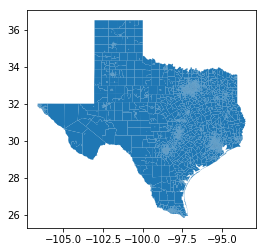

In [9]:
#the raw data is all of texas
census_tracts_2010.plot()

In [10]:
#filter the spatial data so that it only includes the tracts also present in the 2010 race data (i.e. Harris county)
census_tracts_2010_harris = census_tracts_2010.loc[census_tracts_2010["GEO_ID"].isin(race_2010["id"])]
census_tracts_2010_harris.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry
429,1400000US48201100000,48,201,100000,1000,Tract,1.472,"POLYGON ((-95.37348 29.75100, -95.37413 29.751..."
430,1400000US48201210900,48,201,210900,2109,Tract,0.488,"POLYGON ((-95.32851 29.80846, -95.32423 29.809..."
431,1400000US48201211000,48,201,211000,2110,Tract,0.433,"POLYGON ((-95.32400 29.79395, -95.32447 29.793..."
432,1400000US48201211600,48,201,211600,2116,Tract,0.450,"POLYGON ((-95.31590 29.78414, -95.31587 29.784..."
433,1400000US48201211900,48,201,211900,2119,Tract,0.482,"POLYGON ((-95.30320 29.78751, -95.29906 29.787..."


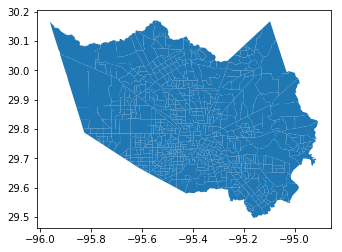

In [11]:
census_tracts_2010_harris.plot()

#   
## Combining race table and shape data

So that race data could be overlayed on map plots, I merged the two tables by tract id. The plots below are the percent of each racial group making up each census tract for 2010 and 2018 respectively. Note that the color scale is not consistent. These plots elucidate the racial segregation (for whatever reason) still present in Houston neightborhoods. 

In [12]:
tracts_race_merged = census_tracts_2010_harris.merge(race_merged, how="left", left_on='GEO_ID', right_on="id")
#tracts_race_merged.head()

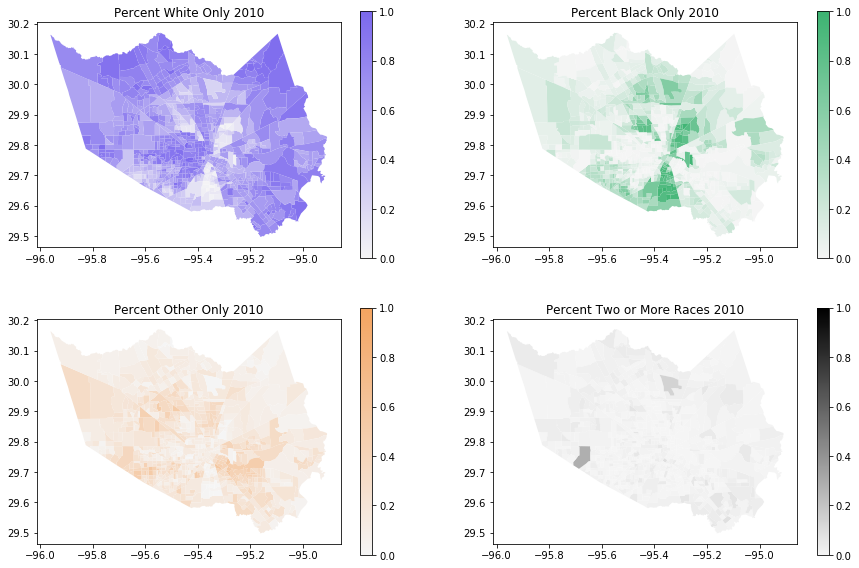

In [182]:
figure, axes = plt.subplots(2, 2, figsize=(15,10))

white_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","mediumslateblue"], N=256)
black_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","mediumseagreen"], N=256)
other_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","sandybrown"], N=256)
mixed_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","black"], N=256)

tracts_race_merged.plot(ax=axes[0,0], column='percent_white_2010', 
                         categorical=False, cmap = white_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent White Only 2010")

tracts_race_merged.plot(ax=axes[0,1],column='percent_black_2010', 
                         categorical=False, cmap = black_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent Black Only 2010")

tracts_race_merged.plot(ax=axes[1,0],column='percent_other_2010', 
                         categorical=False, cmap = other_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent Other Only 2010")

tracts_race_merged.plot(ax=axes[1,1],column='percent_mixed_2010', 
                         categorical=False, cmap = mixed_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent Two or More Races 2010")

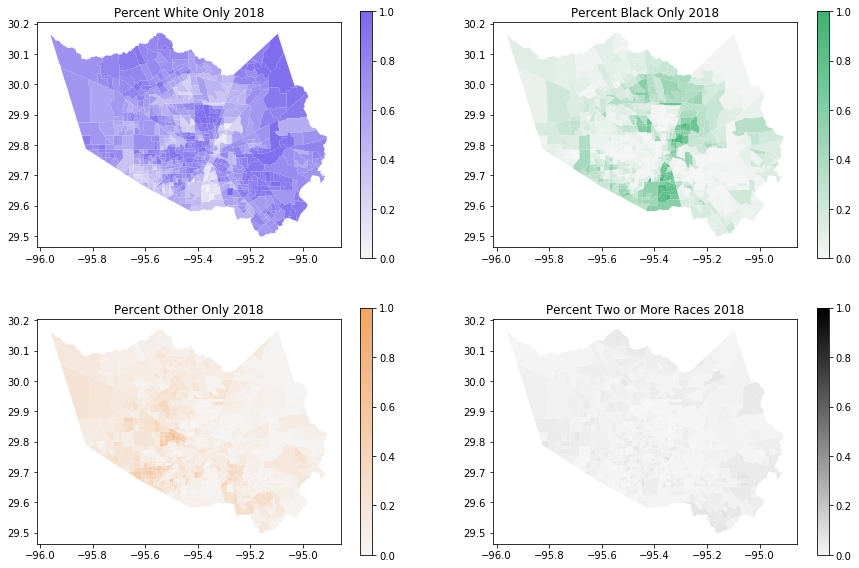

In [181]:
figure, axes = plt.subplots(2, 2, figsize=(15,10))

white_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","mediumslateblue"], N=256)
black_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","mediumseagreen"], N=256)
other_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","sandybrown"], N=256)
mixed_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","black"], N=256)

tracts_race_merged.plot(ax=axes[0,0], column='percent_white_2018', 
                         categorical=False, cmap = white_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent White Only 2018")

tracts_race_merged.plot(ax=axes[0,1],column='percent_black_2018', 
                         categorical=False, cmap = black_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent Black Only 2018")

tracts_race_merged.plot(ax=axes[1,0],column='percent_other_2018', 
                         categorical=False, cmap = other_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent Other Only 2018")

tracts_race_merged.plot(ax=axes[1,1],column='percent_mixed_2018', 
                         categorical=False, cmap = mixed_colorbar,vmin=0, vmax=1,
                         legend=True).set_title("Percent Two or More Races 2018")

#  
## Redlining

### Background
Formal redlining in the U.S. began with the Federal Housing Act of 1934's establishment of the Home Owners' Loan Corporation (HOLC). The HOLC was tasked with establishing "residential security maps" of major U.S. cities to categorize neighborhoods desirabilities for real-estate loans. "Type A" (green) neighborhoods, were desirable, newly-established affluent suburbs. "Type B" (blue) areas were  "still desirable" for lending. "Type C" (yellow) were considered less-desirable, "declining" neighborhoods which were only ocassionally approved for loans. "Redlining" gets its name from the "Type D" neighborhoods, which were labelled "hazardous" and outlined with red lines. These neighborhoods were predominantly black neighborhoods, and were categorically denied loans. 

### Data
The original source of the data is the 1930's HOLC map of Houston   
![image](TX_Houston/redlining.png). 

For modern analysis, Richmond University's Mapping Inequality Project has digitized these maps into shape files. (https://dsl.richmond.edu/panorama/redlining/#loc=12/29.742/-95.391&maps=0&city=houston-tx&text=downloads)  
I am using the shapefile for Houston, which is a series of polygons labeled with the HOLC type. 

### Processing
The 1930's neighborhoods do not line up to modern census tracts. A considerable portion of this code is dedicated to intersecting the census shape files and the redlining shape files to quantify the portion of a modern census tract that was historically assigned to each HOLC type. More information in the code comments.

In [15]:
#historial redlining tracts
redlining_1938 = gpd.read_file('/Users/aschalck/Desktop/final_project/redlining/cartodb-query.shp')

In [16]:
#the data is super old and does not match modern census tracts
#grade is "how safe it is to give people here a mortgage"
#'A' is almost certain to get a mortgage, 'D' is prohibited to get loans 
redlining_1938.head(5)

,name,holc_id,holc_grade,geometry
0,None,None,B,"POLYGON ((-95.28720 29.68536, -95.28725 29.688..."
1,None,None,C,"POLYGON ((-95.31492 29.69646, -95.31321 29.696..."
2,None,None,B,"POLYGON ((-95.35530 29.69472, -95.34920 29.692..."
3,None,None,C,"POLYGON ((-95.35798 29.68852, -95.35199 29.686..."
4,None,None,C,"POLYGON ((-95.36782 29.70588, -95.37046 29.698..."


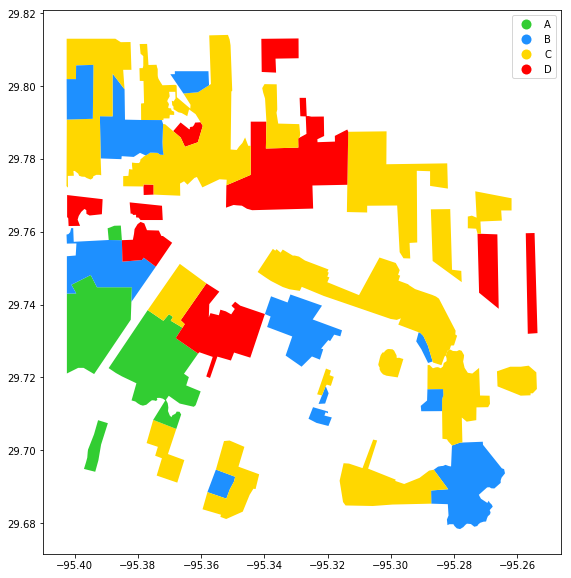

In [40]:
#plotting just the redlining map
redline_colors = ListedColormap(["limegreen","dodgerblue","gold","red"])
redlining_1938_layer = redlining_1938.plot(column='holc_grade', 
                         categorical=True, 
                         legend=True, 
                         figsize=(10,10),
                         cmap=redline_colors)

Overlaying the redlining plot over Harris county. It only emcompases a small part of the city. (Houston was quite small in the 1930's)

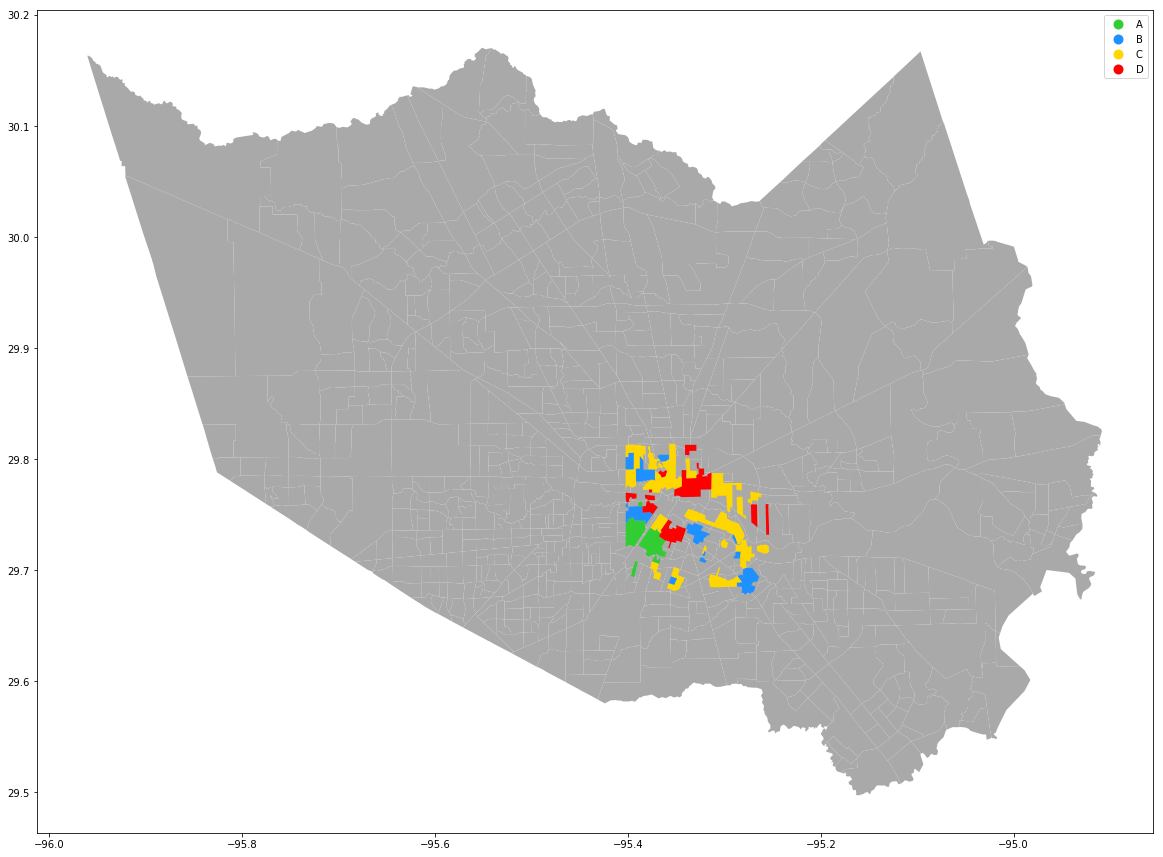

In [18]:
#overlay plot
harris_tracts_plot_2010 = census_tracts_2010_harris.plot(figsize=(20,20), color='darkgrey')
redlining_1938.plot(ax = harris_tracts_plot_2010,
                    column='holc_grade', 
                         categorical=True, 
                         legend=True, 
                         figsize=(20,20),
                         cmap=redline_colors)

In [19]:
#function that quantifies the percent of a modern tract that is in a neighborhood from the redlining data
def intersect_tract_hood(tracts_df, hoods_df, colname):

    geom_tract = [shape(feat["geometry"]) for k, feat in tracts_df.iterrows()]
    geom_hood = [shape(feat["geometry"]) for k, feat in hoods_df.iterrows()]

    out_df = pd.DataFrame(tracts_df["id"])
    out_df[colname] = 0
    
    for i, tract in enumerate(geom_tract):
        for j, hood in enumerate(geom_hood):
            if tract.intersects(hood):
                out_df.loc[i,colname] += tract.intersection(hood).area/tract.area
   
    return(out_df)

In [20]:
#calculate the percentage for each tract, for each  redlining grade
tracts_race_redline = tracts_race_merged

grades = ["A","B","C","D"]

for k in grades:
    hood_grade = redlining_1938.loc[redlining_1938["holc_grade"] == k]
    hood_intersect = intersect_tract_hood(tracts_race_merged, hood_grade, k)
    hood_intersect[k] = hood_intersect[k].round(4)
    tracts_race_redline = tracts_race_redline.merge(hood_intersect, how="left", on="id") 

#'U' is for "unassigned" to a redlining tract
tracts_race_redline["U"] = 1-tracts_race_redline[grades].sum(axis=1)
tracts_race_redline.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,id,total_2010,...,total_2018,percent_white_2018,percent_black_2018,percent_mixed_2018,percent_other_2018,A,B,C,D,U
0,1400000US48201100000,48,201,100000,1000,Tract,1.472,"POLYGON ((-95.37348 29.75100, -95.37413 29.751...",1400000US48201100000,3853,...,5063,0.676674,0.206399,0.026467,0.090460,0.0,0.0,0.0710,0.0717,0.8573
1,1400000US48201210900,48,201,210900,2109,Tract,0.488,"POLYGON ((-95.32851 29.80846, -95.32423 29.809...",1400000US48201210900,1844,...,1209,0.129859,0.698098,0.010753,0.161290,0.0,0.0,0.0000,0.0988,0.9012
2,1400000US48201211000,48,201,211000,2110,Tract,0.433,"POLYGON ((-95.32400 29.79395, -95.32447 29.793...",1400000US48201211000,1479,...,1941,0.356002,0.569294,0.005152,0.069552,0.0,0.0,0.2481,0.0577,0.6942
3,1400000US48201211600,48,201,211600,2116,Tract,0.450,"POLYGON ((-95.31590 29.78414, -95.31587 29.784...",1400000US48201211600,3173,...,2749,0.609676,0.208439,0.007275,0.174609,0.0,0.0,0.7494,0.2506,0.0000
4,1400000US48201211900,48,201,211900,2119,Tract,0.482,"POLYGON ((-95.30320 29.78751, -95.29906 29.787...",1400000US48201211900,5143,...,5478,0.784593,0.007850,0.012048,0.195509,0.0,0.0,0.3798,0.0000,0.6202


In [21]:
#calculate the percentage change of each race for each tract from 2010 to 2018
tracts_race_redline["white_only_change"] = round(tracts_race_redline["percent_white_2018"] - tracts_race_redline["percent_white_2010"],2)
tracts_race_redline["black_only_change"] = round(tracts_race_redline["percent_black_2018"] - tracts_race_redline["percent_black_2010"],2)
tracts_race_redline["other_only_change"] = round(tracts_race_redline["percent_other_2018"] - tracts_race_redline["percent_other_2010"],2)
tracts_race_redline["mixed_change"] = round(tracts_race_redline["percent_mixed_2018"] - tracts_race_redline["percent_mixed_2010"],2)
tracts_race_redline.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,id,total_2010,...,percent_other_2018,A,B,C,D,U,white_only_change,black_only_change,other_only_change,mixed_change
0,1400000US48201100000,48,201,100000,1000,Tract,1.472,"POLYGON ((-95.37348 29.75100, -95.37413 29.751...",1400000US48201100000,3853,...,0.090460,0.0,0.0,0.0710,0.0717,0.8573,0.13,-0.12,-0.01,0.01
1,1400000US48201210900,48,201,210900,2109,Tract,0.488,"POLYGON ((-95.32851 29.80846, -95.32423 29.809...",1400000US48201210900,1844,...,0.161290,0.0,0.0,0.0000,0.0988,0.9012,-0.08,-0.02,0.09,0.01
2,1400000US48201211000,48,201,211000,2110,Tract,0.433,"POLYGON ((-95.32400 29.79395, -95.32447 29.793...",1400000US48201211000,1479,...,0.069552,0.0,0.0,0.2481,0.0577,0.6942,0.32,-0.27,-0.05,0.01
3,1400000US48201211600,48,201,211600,2116,Tract,0.450,"POLYGON ((-95.31590 29.78414, -95.31587 29.784...",1400000US48201211600,3173,...,0.174609,0.0,0.0,0.7494,0.2506,0.0000,-0.04,0.04,0.00,0.01
4,1400000US48201211900,48,201,211900,2119,Tract,0.482,"POLYGON ((-95.30320 29.78751, -95.29906 29.787...",1400000US48201211900,5143,...,0.195509,0.0,0.0,0.3798,0.0000,0.6202,0.08,0.00,-0.09,0.01


In [22]:
#create a filtered version of the geodata that only contains the tracts that have redlining information
tracts_race_redline_filter = tracts_race_redline.loc[tracts_race_redline["U"]<1].copy()

In [160]:
#save tract id's incase needed for later...
#i dont' think I actually used them late...
redlined_tracts = tracts_race_redline.loc[tracts_race_redline["U"]<1]["id"]
unknown_tracts = tracts_race_redline.loc[tracts_race_redline["U"]==1]["id"]

# 
## Percentage of tract rating

These plots are mostly a check to see if the intersection worked. For each (rated) tract, it shows how much of that tract has a given rating. Most tracts historically had different sections rated differently. Notably, the larger bright red section on the D-rating plot is Houston's 5th ward neighborhood. 

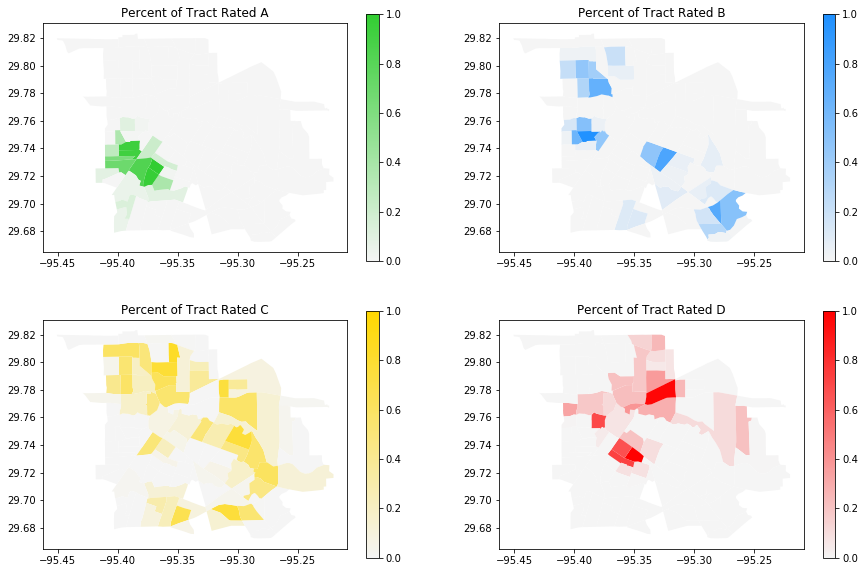

In [183]:
figure, axes = plt.subplots(2, 2, figsize=(15,10))

A_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","limegreen"], N=256)
B_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","dodgerblue"], N=256)
C_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","gold"], N=256)
D_colorbar = clr.LinearSegmentedColormap.from_list('custom', ["whitesmoke","red"], N=256)

tracts_race_redline_filter.plot(ax=axes[0,0], column='A', 
                         categorical=False, cmap = A_colorbar,vmin=0, vmax=1,
                         legend=True).set_title('Percent of Tract Rated A')

tracts_race_redline_filter.plot(ax=axes[0,1],column='B', 
                         categorical=False, cmap = B_colorbar,vmin=0, vmax=1,
                         legend=True).set_title('Percent of Tract Rated B')

tracts_race_redline_filter.plot(ax=axes[1,0],column='C', 
                         categorical=False, cmap = C_colorbar,vmin=0, vmax=1,
                         legend=True).set_title('Percent of Tract Rated C')

tracts_race_redline_filter.plot(ax=axes[1,1],column='D', 
                         categorical=False, cmap = D_colorbar,vmin=0, vmax=1,
                         legend=True).set_title('Percent of Tract Rated D')

# 
## Redlining grade and 2010 racial composition

These plots are the percentage of a tract rated at a historical grade vs. the tract's 2010 racial composition. These plots show that (with some exceptions) tracts that are predominantly black in modern times, tended to historically be graded mostly C and D. Also, tracts that are highly white today, tend to not have experienced redlining (not highly rated D) in the past. 

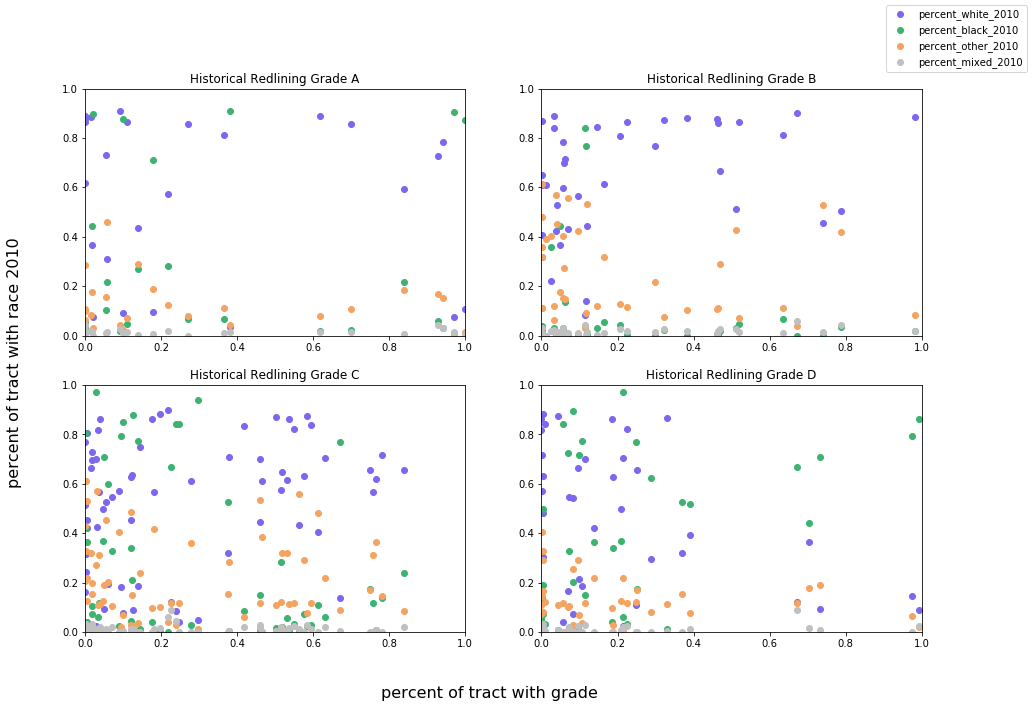

In [194]:
grades = ["A","B","C","D","U"]
groups = ['percent_white_2010','percent_black_2010','percent_other_2010','percent_mixed_2010']
race_colors = ["mediumslateblue","mediumseagreen","sandybrown","silver"]

fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.flatten()

for ind, i in enumerate(grades[0:4]):
    temp = tracts_race_redline.loc[tracts_race_redline[i]>0]
    #plt.scatter(ax=ind)
    for jnd, j in enumerate(groups):
        ax[ind].scatter(x=temp[i],
                      y=temp[j], color=race_colors[jnd])
    ax[ind].set_title("Historical Redlining Grade " +i)
    ax[ind].set_xlim(0,1)
    ax[ind].set_ylim(0,1)
    #ax[ind].set_xlabel("percent of tract with grade")
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.text(0.5, 0.04, 'percent of tract with grade', ha='center', va='center', size=16)
fig.text(0.06, 0.5, 'percent of tract with race 2010', ha='center', va='center', size=16,rotation='vertical')
plt.show()

#  
This is a similar style of plot to the previous, however when assigning each tract one grade (it's most common), the differences between racial groups become much more apparant. Tracts that were historically graded mostly "D" are much more likely to have a high fraction of black consituents today. Highly white tracts, tend to have historically been mostly graded "A" or "B".

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d54f1d0>,
      dtype=object)

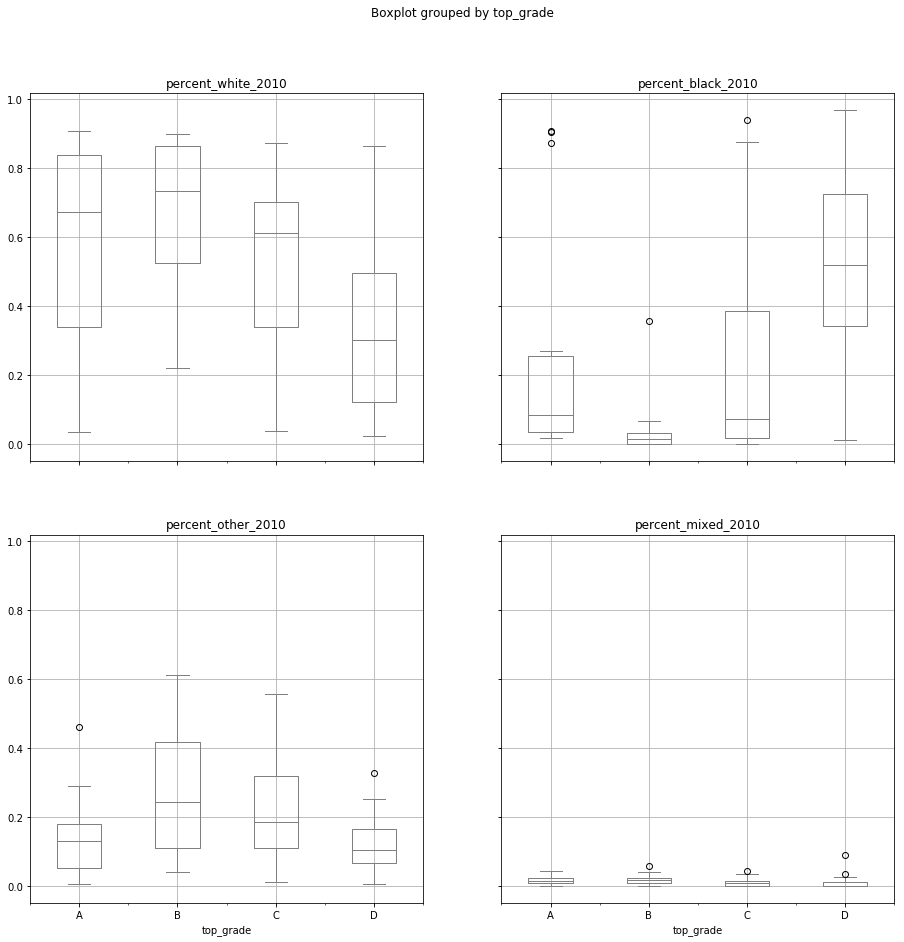

In [26]:
#identify the most historical grade that makes up the largest percentage of the census tract
#called "top_grade"
tracts_race_redline_filter["top_grade"] = tracts_race_redline_filter.loc[:,["A","B","C","D"]].idxmax(axis="columns")

#plot race percentage by the predominant tract grade
tracts_race_redline_filter.boxplot(column = ["percent_white_2010","percent_black_2010","percent_other_2010","percent_mixed_2010"],
                                   by="top_grade",figsize=(15,15), color = "grey")

# 
## Redlining grade change in racial composition

These plots are the percentage of a tract rated at a historical grade vs. the change in racial composition from 2010 to 2018. For almost all tracts, there is an increase in the percentage of white-only people, for all historical grades. Since the area we are examining is in the center of the city, I think it should be speculated that this is due to gentrification of the inner city area. Also, it appears that areas historically graded as Type A have less variance in racial composition change than other grades.  

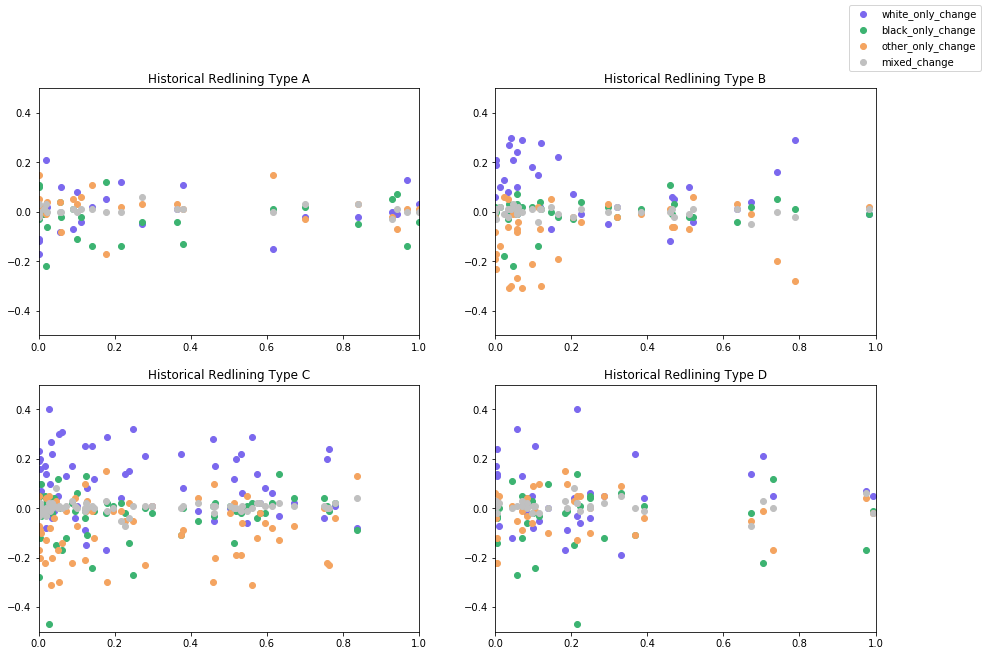

In [27]:
grades = ["A","B","C","D","U"]
groups = ['white_only_change','black_only_change','other_only_change','mixed_change']
race_colors = ["mediumslateblue","mediumseagreen","sandybrown","silver"]

fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.flatten()

for ind, i in enumerate(grades[0:4]):
    temp = tracts_race_redline.loc[tracts_race_redline[i]>0]
    #plt.scatter(ax=ind)
    for jnd, j in enumerate(groups):
        ax[ind].scatter(x=temp[i],
                      y=temp[j], color=race_colors[jnd])
    ax[ind].set_title("Historical Redlining Type " +i)
    ax[ind].set_xlim(0,1)
    ax[ind].set_ylim(-0.5,0.5)
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.show()

#  
## Deed restrictions

### Background

In cities without zoning, deed restrictions allow residential communities to enforce neighborhood building aesthetic rules. Today, they are largely used to prevent high-density housing, and commercial developlent of residential neighborhoods. However, historically deed restrictions in Houston were often used to restrict who could buy a house in the neighborhood. Despite racial restrictions on housing now being un-enforceable, several [(As reported by the Houston Chronicle)](https://www.houstonchronicle.com/business/real-estate/article/Race-limits-are-banned-but-language-lives-on-in-14106726.php#photo-17877662) deed restrictions in Houston still retain the antiquated "whites-only" clause in their documentation, and others have only recently removed the language. This section of the report examines the racial composition of these neighborhoods and how it's changing in relation to deed restriction language-status.

### Deed restriction data

As far as I could find, there is no JSON data of all Houston deed restriction boundaries. Therefore, this data was manually currated from the above-mentioned chronical article. I compared the neighborhoods rastor-mapped in the article to the 2010 census tracts, and mapped each tract as having 'half', 'most', or 'some' of the tract containing the neighborhood. I compiled deed restriction language status from the article, with'curent' meaning "whites-only" is still in the restriction (e.g. Oak Forest East), 'recent' meaning it was present and only recently was removed (e.g. Braeswood removed theirs this decade), and 'never' for neighborhoods which never had race-prohibiting deed restrictions (e.g. Oak Forest West). For most tracts, the deed restriction status is unknown (and would take lots of individual records requests to obtain).

### Preparing the deed data

This data needed little preparation besides appending to the tract id so that it matched that of the spatial data for merging. The rest of the code is pretty much plots.

In [28]:
deeds_raw = pd.read_csv("/Users/aschalck/Desktop/final_project/deed_restrictions.csv")
deeds_raw.head()

,tract_2010,Neighborhood,restriction,degree
0,531600,Oak Forest East,current,half
1,531200,Oak Forest East,current,most
2,531700,Oak Forest East,current,most
3,531000,Oak Forest East,current,most
4,531100,Oak Forest East,current,most


In [29]:
#process the tract name so that it can be merged
deeds_raw["id"] = "1400000US48201" + deeds_raw["tract_2010"].astype(str)

#merge to the census tract and race data table
tracts_race_deeds_merged = tracts_race_redline.merge(deeds_raw, how="left", on="id")
tracts_race_deeds_merged.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,id,total_2010,...,D,U,white_only_change,black_only_change,other_only_change,mixed_change,tract_2010,Neighborhood,restriction,degree
0,1400000US48201100000,48,201,100000,1000,Tract,1.472,"POLYGON ((-95.37348 29.75100, -95.37413 29.751...",1400000US48201100000,3853,...,0.0717,0.8573,0.13,-0.12,-0.01,0.01,NaN,NaN,NaN,NaN
1,1400000US48201210900,48,201,210900,2109,Tract,0.488,"POLYGON ((-95.32851 29.80846, -95.32423 29.809...",1400000US48201210900,1844,...,0.0988,0.9012,-0.08,-0.02,0.09,0.01,NaN,NaN,NaN,NaN
2,1400000US48201211000,48,201,211000,2110,Tract,0.433,"POLYGON ((-95.32400 29.79395, -95.32447 29.793...",1400000US48201211000,1479,...,0.0577,0.6942,0.32,-0.27,-0.05,0.01,NaN,NaN,NaN,NaN
3,1400000US48201211600,48,201,211600,2116,Tract,0.450,"POLYGON ((-95.31590 29.78414, -95.31587 29.784...",1400000US48201211600,3173,...,0.2506,0.0000,-0.04,0.04,0.00,0.01,NaN,NaN,NaN,NaN
4,1400000US48201211900,48,201,211900,2119,Tract,0.482,"POLYGON ((-95.30320 29.78751, -95.29906 29.787...",1400000US48201211900,5143,...,0.0000,0.6202,0.08,0.00,-0.09,0.01,NaN,NaN,NaN,NaN


In [161]:
#replace the NAN's with "unknown"
tracts_race_deeds_merged['Neighborhood'] = tracts_race_deeds_merged['Neighborhood'].fillna("unknown")
tracts_race_deeds_merged['restriction'] = tracts_race_deeds_merged['restriction'].fillna("unknown")
tracts_race_deeds_merged['degree'] = tracts_race_deeds_merged['degree'].fillna("unknown")
#tracts_race_deeds_merged.head()

#  
Like the redlining data, most of the studied neighborhoods are within the 610 loop.

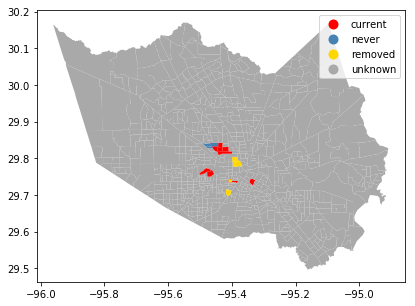

In [190]:
restriction_colors =  ListedColormap(["red",'steelblue','gold','darkgrey'])
tracts_race_deeds_merged.plot(column='restriction', 
                         categorical=True, 
                         legend=True, 
                         figsize=(15,5),cmap=restriction_colors)

#  
Average change in racial composition, grouped by the tract's deed restriction status.  

In [128]:
tracts_race_deeds_merged.groupby("restriction")[["white_only_change","black_only_change","other_only_change","mixed_change"]].mean()

,white_only_change,black_only_change,other_only_change,mixed_change
restriction,,,,
current,0.024545,0.016364,-0.049091,0.007273
never,-0.076667,0.023333,0.066667,-0.013333
removed,-0.005000,-0.001667,-0.003333,0.010000
unknown,0.033138,-0.008281,-0.031380,0.006549


#  
Kernal density plots of the change in racial composition (from 2010 to 2018) of each race, split by deed restiction status. This indicated that the above chart is probably misleading because the data is often bimodal (which may be due to having few tracts for some groups).

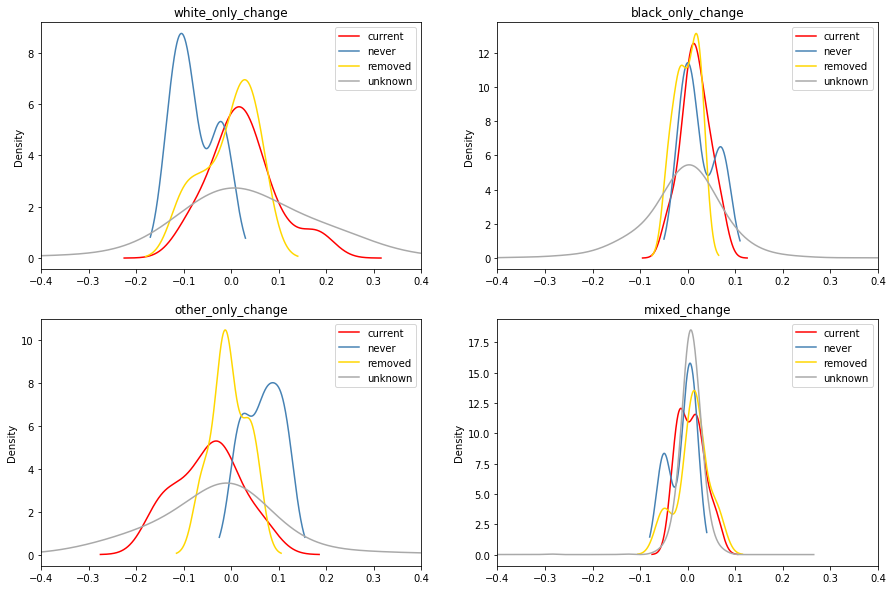

In [184]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.flatten()
[a.set_prop_cycle('color',["red",'steelblue','gold','darkgrey']) for a in ax]
for i, group in enumerate(groups):
    for idx, gp in tracts_race_deeds_merged.groupby("restriction"):
        gp[group].plot(kind='kde', bw_method=0.5, legend=True, xlim = [-0.4,0.4], label=idx, ax=ax[i], title=group)

#
### Oak Forest

Oak Forest East is notably for being one of the largest neighborhoods still harboring "whites-only" deed restriction language. It is also interesting because the adjacent neighborhood Oak Forest West never had a race-limiting deed restriction, even when it was enforceable. 

In [191]:
oak_forest = tracts_race_deeds_merged.loc[tracts_race_deeds_merged["Neighborhood"].isin(["Oak Forest East", "Oak Forest West"])].copy()

### Plot notes
1. Oak Forest East and West are adjacent, and share one census tract between them (green) about equally.
2. Several tracts are almost exclusively Oak Forest East, but Oak Forest West partially covers 3 tracts. 
3. Oak Forest East is currently race-restricted in the deed. Oak Forest West never had such a restriction. 
4. The only significant black population (2010) in these neighborhoods is present in the never-race restricted, Oak Forest West. 

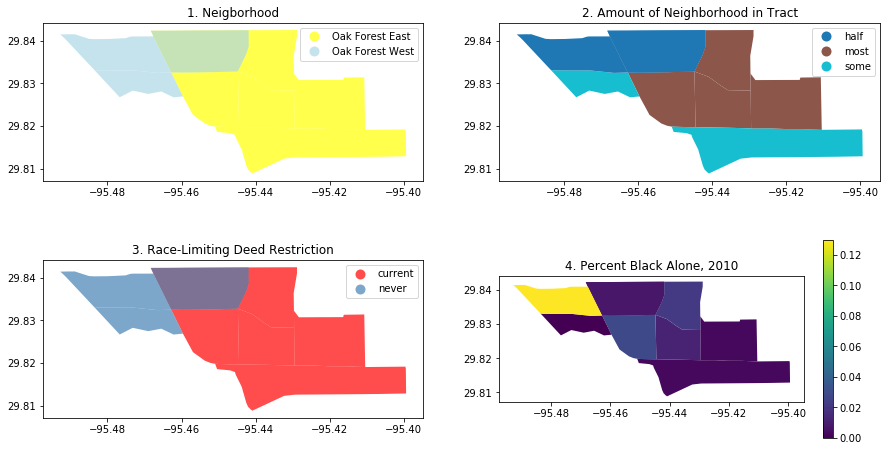

In [159]:
figure, axes = plt.subplots(2, 2, figsize=(15,8))

oak_forest_colors =  ListedColormap(["yellow",'lightblue'])
oak_forest.plot(column='Neighborhood', 
                         categorical=True, 
                         legend=True, 
                         figsize=(15,5), 
                         alpha=0.7, 
                         cmap = oak_forest_colors, 
                         ax=axes[0,0]).set_title('1. Neigborhood')

oak_forest.plot(column='degree', 
                         categorical=True, 
                         legend=True, 
                         figsize=(15,5),ax=axes[0,1]).set_title('2. Amount of Neighborhood in Tract')

restriction_colors =  ListedColormap(["red",'steelblue'])
oak_forest.plot(column='restriction', 
                         categorical=True, 
                         legend=True, alpha=0.7, cmap = restriction_colors,
                         figsize=(15,5),ax=axes[1,0]).set_title('3. Race-Limiting Deed Restriction')

oak_forest.plot(column='percent_black_2010', 
                         categorical=False, 
                         legend=True, 
                         figsize=(15,5), ax=axes[1,1]).set_title('4. Percent Black Alone, 2010')

#  
# Conclustion
Racial segregation in houseing is clearly present in Houston today, and is related to historical neighborhood assesment boundaries. Some of this segregation is still reflected in deed restriction language today. 

# Limitations
This study is limited by examining data at the census tract level, rather than at the "block" level. Therefore, many areas are probably being mislabeled and diluting the effects of redlining. Additionally, there are many deed restricted communities not listed. It would be a better comparison to have more neighborhoods which never had race-restrictions as a control. Additionally, this study does not examine any financial or real estate data which would help to further explain what is happening. 
